In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.model_selection import cross_val_score
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier as knn
from imblearn.over_sampling import BorderlineSMOTE
import collections
from sklearn.externals import joblib
from mlxtend.plotting import plot_decision_regions

In [3]:
X_train=pd.read_excel("X_train.xlsx")
y_train=pd.read_excel("y_train.xlsx")

X_test=pd.read_excel("X_test.xlsx")
y_test=pd.read_excel("y_test.xlsx")

In [4]:
print(X_train.shape)
X_train.head()

(32615, 13)


,Para_First,Position,Length,Quote,Doc_First,FirstRel_Doc,FirstRel_Para,PageRankRel,CentroidVar_Uni,CentroidVar_Bi,FreqWord_Uni,FreqWord_Bi,SigTerm_Uni
0,1,1.000000,15,1.0,1,1.000000,1.000000,1.092140,0.247286,0.345769,0.811746,1.000000,0.802003
1,1,1.000000,14,1.0,0,0.000000,1.000000,0.791002,0.273988,0.370171,0.803571,1.000000,0.000000
2,0,0.500000,9,1.0,0,0.086066,0.089087,1.762937,0.312076,0.431832,0.562169,0.916667,0.000000
3,0,0.333333,13,1.0,0,0.071611,0.000000,0.804663,0.264028,0.368563,0.842308,1.000000,0.802003
4,1,1.000000,8,1.0,0,0.000000,1.000000,0.790716,0.350765,0.481579,0.718750,1.000000,0.000000


In [5]:
sm = BorderlineSMOTE(random_state=12,sampling_strategy='minority',n_jobs=-1)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/home/dhruv/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [6]:
collections.Counter(y_train_res)

Counter({1: 20252, 0: 20252})

In [7]:
scaler = preprocessing.MinMaxScaler()
print(scaler.fit(x_train_res))
x_train_res=scaler.transform(x_train_res)

X_test=scaler.transform(X_test)

y_train_res=np.array(y_train_res)
y_test=np.array(y_test)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [10]:
# tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
# model=GridSearchCV(svm.SVC(), tuned_parameters,  cv=5,scoring="f1",n_jobs=-1)

# # model=svm.SVC(kernel='rbf')
# model.fit(x_train_res, y_train_res)
train_scores=[]
test_scores=[]
neighbors = list(range(1,120))
for i in neighbors:
    model = knn(n_neighbors=i)
#     model.fit(x_train_res, y_train_res)
    scores_train = cross_val_score(model, x_train_res, y_train_res.ravel(), cv=5)
    score_mean=np.mean(scores_train)
    train_scores.append(score_mean)
    
    scores_test = cross_val_score(model, X_test, y_test.ravel(), cv=5)
    score_mean_test=np.mean(scores_test)
    test_scores.append(score_mean_test)
    

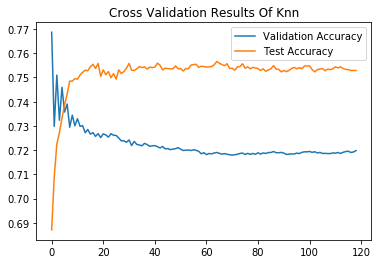

In [15]:
plt.plot(train_scores,label='Validation Accuracy')
plt.plot(test_scores,label='Test Accuracy')
plt.title("Cross Validation Results Of Knn")
plt.legend()
plt.show()

In [8]:
final_model=knn(n_neighbors=60)
final_model.fit(x_train_res, y_train_res.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=60, p=2,
           weights='uniform')

In [9]:
y_cap = final_model.predict(X_test)

In [10]:
metrics.f1_score(y_cap,y_test)

0.6876600102406554

In [11]:
metrics.accuracy_score(y_cap,y_test)

0.7174290677475391

In [12]:
metrics.confusion_matrix(y_test,y_cap)

array([[3509, 1870],
       [ 570, 2686]])

In [26]:
model_tSNE = TSNE(n_components=2, random_state=0)
tsne_data = model_tSNE.fit_transform(x_train_res)

Text(0.5,1,'KNN Decision Boundary')

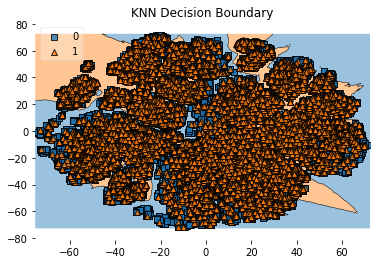

In [33]:
plot_decision_regions(tsne_data, y_train_res, clf=knn(n_neighbors=60).fit(tsne_data,y_train_res), legend=2)
plt.title("KNN Decision Boundary")

In [34]:
filename = 'tsne data on borderline min max scale.sav'
pickle.dump(tsne_data, open(filename, 'wb'))

In [13]:
import glob 
from nltk import sent_tokenize
import nltk

def get_document_without_heading(fname, is_summ = False):
    file = open(fname,"r") 
    line = file.read()
    sent_text = nltk.sent_tokenize(line)
    for sent in sent_text:
        if(len(sent) == 1):
            sent_text.remove(sent)
    if is_summ is False:
        heading = sent_text.pop(0)
        heading = heading.split('\n\n')
        if len(heading) > 1:
            sent_text.insert(0,heading[1])
    return sent_text

In [14]:
test_labels = y_cap.copy()
data_paths = []
for path in glob.glob("updated_data/Test_Data/*.txt"):
    data_paths.append(path)
data_paths.sort()
for i in range(len(data_paths)):
    summ = ''
    p = data_paths[i].split("/")[-1]
    summ_path = "KNN_Predicted_Summ/" + p
    original_doc = get_document_without_heading(data_paths[i], is_summ = False )
    doc_labels = test_labels[:len(original_doc)]
    test_labels = test_labels[len(original_doc):]
    print(p)
    print(len(original_doc))
    print(len(doc_labels))
    print("left is : " + str(len(test_labels)) + "\n")
    
    for i in range(len(original_doc)):
        if doc_labels[i] == 1:
            summ = summ + original_doc[i] + " "
    summ = summ[:-1]
    f = open(summ_path,'w')
    f.write(summ)
    f.close()

1.txt
31
31
left is : 8604

10.txt
8
8
left is : 8596

100.txt
10
10
left is : 8586

101.txt
15
15
left is : 8571

102.txt
7
7
left is : 8564

103.txt
8
8
left is : 8556

104.txt
9
9
left is : 8547

105.txt
24
24
left is : 8523

106.txt
13
13
left is : 8510

107.txt
11
11
left is : 8499

108.txt
52
52
left is : 8447

109.txt
20
20
left is : 8427

11.txt
11
11
left is : 8416

110.txt
23
23
left is : 8393

111.txt
8
8
left is : 8385

112.txt
8
8
left is : 8377

113.txt
17
17
left is : 8360

114.txt
10
10
left is : 8350

115.txt
19
19
left is : 8331

116.txt
13
13
left is : 8318

117.txt
26
26
left is : 8292

118.txt
9
9
left is : 8283

119.txt
19
19
left is : 8264

12.txt
11
11
left is : 8253

120.txt
29
29
left is : 8224

121.txt
13
13
left is : 8211

122.txt
15
15
left is : 8196

123.txt
13
13
left is : 8183

124.txt
11
11
left is : 8172

125.txt
11
11
left is : 8161

126.txt
10
10
left is : 8151

127.txt
13
13
left is : 8138

128.txt
17
17
left is : 8121

129.txt
13
13
left is : 8108


427.txt
42
42
left is : 1626

428.txt
29
29
left is : 1597

429.txt
13
13
left is : 1584

43.txt
14
14
left is : 1570

430.txt
40
40
left is : 1530

431.txt
18
18
left is : 1512

432.txt
31
31
left is : 1481

433.txt
30
30
left is : 1451

434.txt
17
17
left is : 1434

435.txt
14
14
left is : 1420

436.txt
40
40
left is : 1380

437.txt
15
15
left is : 1365

438.txt
20
20
left is : 1345

439.txt
42
42
left is : 1303

44.txt
17
17
left is : 1286

440.txt
42
42
left is : 1244

441.txt
52
52
left is : 1192

442.txt
18
18
left is : 1174

443.txt
15
15
left is : 1159

444.txt
45
45
left is : 1114

445.txt
17
17
left is : 1097

446.txt
16
16
left is : 1081

447.txt
152
152
left is : 929

448.txt
20
20
left is : 909

45.txt
14
14
left is : 895

46.txt
23
23
left is : 872

47.txt
17
17
left is : 855

48.txt
9
9
left is : 846

49.txt
17
17
left is : 829

5.txt
19
19
left is : 810

50.txt
15
15
left is : 795

51.txt
14
14
left is : 781

52.txt
18
18
left is : 763

53.txt
14
14
left is : 749

54.tx